In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional; nn.f = functional
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import string
import torchvision
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
# Batch options
batch_size = 128  # input batch size for training
test_batch = 1    # test batch size

# Normalizes the input images for a better training
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

# Get train and test loaders to load MNIST data
trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

# Create the dataloaders on which we can iterate to get the data in batch_size chunks
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=0)

In [5]:
labelDict = None
vocab = None
# Creating dictionary and Lookup Table ###########################################
labelDict = {
    0: "<b>zero<e>",
    1: "<b>one<e>",
    2: "<b>two<e>",
    3: "<b>three<e>",
    4: "<b>four<e>",
    5: "<b>five<e>",
    6: "<b>six<e>",
    7: "<b>seven<e>",
    8: "<b>eight<e>",
    9: "<b>nine<e>"
}
characters = set()
for word in labelDict.values():
    word_clean = word[3:-3]  # Strip the boundary tokens
    characters.update(word_clean)

vocab = ['<b>', '<e>'] + sorted(characters)

################################################################################
vocab.sort()
vocab_size = len(vocab)
print(vocab)

# Testing
assert(vocab_size == 17)
assert(len(labelDict) == 10)

['<b>', '<e>', 'e', 'f', 'g', 'h', 'i', 'n', 'o', 'r', 's', 't', 'u', 'v', 'w', 'x', 'z']


In [6]:
# Some utility functions to check if code is working as intended
def assert_encoding(actual, expected):
  assert(type(actual) == type(torch.tensor(0)))
  if(not((expected.numpy() == actual.numpy()).all())):
    print('expected: ', expected)
    print('actual: ', actual)
    assert((expected.numpy() == actual.numpy()).all())

# Utility function to assert shape of a tensor, for debugging purpose
def shapeChecker(x, y):
  assert(x.shape == y.shape)

# Get the index of a token in the vocab
def get_idx(letter):
    return [i for i, x in enumerate(vocab) if (letter == x)][0]

In [7]:
# Function to convert a list of labels to a list of one-hot matrix
def label_to_onehot_sequence(label):
    # Retrieve the tokenized string for the given label from labelDict
    tokenized_string = labelDict[label.item()]

    # Handle the tokens properly, treating '<b>' and '<e>' as single tokens
    tokens = []
    i = 0
    while i < len(tokenized_string):
        if tokenized_string[i] == '<':  # Detect the start of a special token
            end_idx = tokenized_string.find('>', i + 1)
            tokens.append(tokenized_string[i:end_idx + 1])
            i = end_idx + 1
        else:
            tokens.append(tokenized_string[i])
            i += 1

    # Convert the tokens into a list of indices based on the vocab
    indices = [vocab.index(token) for token in tokens]

    # Convert list of indices to a tensor
    indices_tensor = torch.tensor(indices, dtype=torch.long)

    # Generate a one-hot encoded tensor from the indices_tensor using nn.f.one_hot
    one_hot_encoded = nn.f.one_hot(indices_tensor, num_classes=len(vocab))

    return one_hot_encoded


assert_encoding(label_to_onehot_sequence(torch.tensor(3)),
  torch.tensor([[
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   # <b>
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],   #  t
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  h
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],   #  r
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  e
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  e
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], # <e>
    dtype=torch.float32))

In [8]:
def batch_of_labels_to_onehot_matrix(labels):
    # Convert labels to one-hot tensors
    onehot_inputs = [label_to_onehot_sequence(label) for label in labels]

    # Pad the length of string since, matrix operation requires fixed-size rows
    max_len = max(len(onehot) for onehot in onehot_inputs)
    padded_onehot = pad_sequence(onehot_inputs, batch_first=True, padding_value= 0)
    return max_len, padded_onehot

# Convert label to label onehot - used in the next to feed argmax input to RNN
def label_to_onehot(target):
    return nn.f.one_hot(target, num_classes=10).to(torch.float32)


In [9]:
# To convert token indices predicted by our model back to characters and form the word
def token_idx_to_token(input):

    # Convert list of token idx to '<b>φ<e>' ##################################
    result = ''.join(vocab[idx] for idx in input)
    return result
    # For each index in the input list, get the corresponding token from vocab, to build the output word
    # example input -> [ 0, 3, 6, 13, 2,  1] -> '<b>five<e>'
    #                    ⬇ ⬇ ⬇   ⬇ ⬇  ⬇
    #                   <b> f  i   v  e  <e>
    return None

assert(token_idx_to_token([0, 3,  6, 13,  2,  1]) == '<b>five<e>')

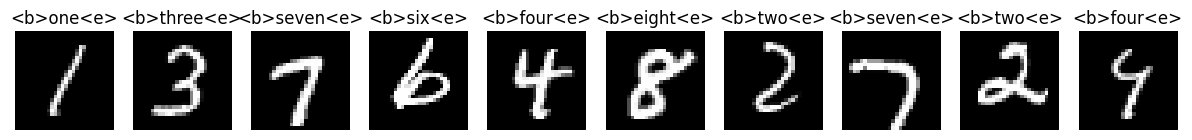

In [10]:
def visualise_images(train_loader, num_images=10):
    # Fetch a single batch of images
    dataiter = iter(train_loader)
    images, labels = dataiter.__next__()  # Use __next__() instead of next()

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Adjust size as needed

    # Display the first 'num_images' images
    for i in range(num_images):
        ax = axes[i]
        img = images[i]  # Get the image tensor
        label = labels[i].item()  # Get the label as a Python value

        # Convert image tensor to numpy for display
        npimg = img.numpy()
        # Handle images with more than one color channel
        if img.shape[0] > 1:
            npimg = np.transpose(npimg, (1, 2, 0))  # Rearrange dimensions to (H, W, C)
        else:
            npimg = npimg.squeeze()  # Remove single-dimensional entries from the array

        # Show the image
        ax.imshow(npimg, cmap='gray')
        # Set the title to the token sequence from labelDict
        ax.set_title(f"{labelDict[label]}")
        ax.axis('off')  # Hide axes ticks

    plt.show()

# Call the function to visualize the images along with the label
visualise_images(train_loader)  # Assuming `train_loader` is your DataLoader object

In [11]:
# Utility function to print statistics for debugging as well as modifies target and output for accuracy calculation
def trainUtility(batch_idx, epoch, output, target, padded_onehot):
    # Printing statistics for easy debugging
    if batch_idx == 1 or (epoch != None and epoch%500==0):
        _, pred_idx = torch.max(output, dim=-1)
        _, true_idx = torch.max(padded_onehot[:, 1:, :], dim=-1)
        print('acc: ', torch.sum(pred_idx == true_idx)/(pred_idx.shape[0]*pred_idx.shape[1]))
        print(pred_idx[0, :], true_idx[0, :])

    # Converting output of size (batch_size x max_word_length-1 x vocab_size) -> ((batch_size*(max_word_length-1)) x vocab_size)
    output =  output.view(-1, vocab_size)
    # Converting the true labels to ((batch_size*(max_word_length-1)) x vocab_size)
    # omitting the first character since, this is not getting predicted by the model
    target = padded_onehot[:, 1:, :].reshape(-1, vocab_size)

    return output, target

In [12]:
class RnnTrainingDataset(Dataset):
    """Dataset to get a tuple of one-hot matrix for each label (batch_size x 10)
       and corresponding one-hot matrix of words (batch_size x max_word_length - 1 x vocab_size)"""

    def __init__(self):
        """
        Arguments:
        """
        self.X = label_to_onehot(torch.tensor([x for x in range(10)]))
        _, self.Y = batch_of_labels_to_onehot_matrix(torch.tensor([x for x in range(10)]))


    def __len__(self):
        return 10 # There are only 10 words

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

rnn_dataset = RnnTrainingDataset()
rnn_dataloader = torch.utils.data.DataLoader(rnn_dataset, batch_size=10, shuffle=True)
rnn_testloader = torch.utils.data.DataLoader(rnn_dataset, batch_size=1, shuffle=True)


In [22]:
# Function which does the training for number of epochs and model and type of model passed
def train(num_epochs, optimiser, model, dataloader=train_loader, mode='ENCODER'):
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    lr_list = []
    for epoch in range(num_epochs):
      for batch_idx, (data, target) in enumerate(dataloader):
          data = data.to(device)
          target = target.to(device)
          optimiser.zero_grad()

          loss = None
          output = None


          if(mode == 'ENCODER'): # CNN classifier
                criterion = torch.nn.CrossEntropyLoss()
                output = model(data)  # Forward pass: compute the model output
                loss = criterion(output, target)  # Calculate loss: Cross entropy loss for classification
                loss.backward()  # Backpropagation
                optimiser.step()  # Optimization step


          elif mode == 'DECODER':  # Overfitting RNN
              # Process inputs and targets
              input_sequence = target[:, :-1, :]  # Exclude the last token for prediction purposes
              output = model(data, input_sequence)  # Generate output from the model

              # Adjust the target to exclude the first token for training comparison
              adjusted_target = target[:, 1:].argmax(dim=-1)  # Convert to class indices for loss calculation

              # Ensure output and adjusted target have the same sequence length
              if output.shape[1] != adjusted_target.shape[1]:
                  # If not, it's likely the output is missing the last sequence element
                  output = output[:, :adjusted_target.shape[1], :]

              # Flatten output and adjusted target for loss calculation
              output_flat = output.reshape(-1, output.shape[-1])
              adjusted_target_flat = adjusted_target.reshape(-1)

              # Calculate loss
              loss = criterion(output_flat, adjusted_target_flat)
              loss.backward()  # Backpropagate the loss
              optimiser.step()  # Update the model parameters

              print("Output flat shape:", output_flat.shape)
              print("Adjusted target flat shape:", adjusted_target_flat.shape)


          if (batch_idx+1) % 100 == 0 or (mode == 'DECODER' and epoch%500 == 0):
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), loss.item()))

In [23]:
def evaluate(model, dataloader=test_loader, mode='ENCODER'):
    # Never forget to change model to eval mode using eval(), this freezes the model weights for updates
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        if(mode == 'ENCODER'):
          # Predicted output
          output = model(data)

          # Calculate correct prediction count
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        elif(mode == 'DECODER'):
          # Predicted output
          output = torch.tensor(model.sample(data), device=device)

          # True output
          _, true = torch.max(target, dim=-1)
          # Remove padding
          true = torch.tensor(np.concatenate(([0],np.delete(true.cpu().numpy(),
                                                            np.argwhere(true.cpu().numpy()==0)))), device=device)

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]
        elif(mode == 'MODULAR'):
          # Predicted output
          output = model.sample(data)

          # True output
          true = [labelDict[label.item()] for label in target]
          true = torch.tensor([0] + [get_idx(c) for c in true[0]] + [1])
          true = torch.full(output.shape, 20) if output.shape[0] != true.shape[0] else true

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]
        elif(mode == 'E2E'):
          # Predicted output
          output = torch.tensor(model.sample(data))

          # True output
          true = [labelDict[label.item()] for label in target]
          true = torch.tensor([0] + [get_idx(c) for c in true[0]] + [1])
          true = torch.full(output.shape, 20) if output.shape[0] != true.shape[0] else true

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]

    test_loss /= len(dataloader.dataset)
    print('\nTest set: Accuracy: {:.0f}/{} ({:.0f}%)\n'.format(
        correct, len(dataloader.dataset),
        100 * correct / len(dataloader.dataset)))

    return 100 * correct / len(dataloader.dataset)

In [24]:
# options
epochs = 10         # number of epochs to train
lr = 0.01           # learning rate

cnnEncoder = None
linearClassifier = None
# Convolutional net architecture ###############################################
class CNN_Encoder(nn.Module):
    def __init__(self, img_size=28):  # Assuming MNIST image size by default
        super(CNN_Encoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Flatten the output for the linear layer
        self.flatten_size = 16 * (img_size // 4 - 3) * (img_size // 4 - 3)
        self.fc = nn.Linear(self.flatten_size, 84)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.flatten_size)
        x = self.fc(x)
        return x

class Linear_Classifier(nn.Module):
    def __init__(self):
        super(Linear_Classifier, self).__init__()
        self.classifier = nn.Linear(84, 10)

    def forward(self, x):
        return self.classifier(x)

################################################################################
cnnEncoder = CNN_Encoder()
linearClassifier = Linear_Classifier()

cnnClassifier = nn.Sequential(cnnEncoder, linearClassifier)
enc_optimiser = optim.SGD(cnnClassifier.parameters(), lr=0.01)

train(epochs, enc_optimiser, cnnClassifier, mode='ENCODER')
acc = evaluate(cnnClassifier, test_loader, mode='ENCODER')
print(f'Accuracy: {acc}%')
assert(acc > 95)

Epoch [1/10], Step [100/469], Loss: 1.9534
Epoch [1/10], Step [200/469], Loss: 0.5896
Epoch [1/10], Step [300/469], Loss: 0.3314
Epoch [1/10], Step [400/469], Loss: 0.4160
Epoch [2/10], Step [100/469], Loss: 0.2322
Epoch [2/10], Step [200/469], Loss: 0.2181
Epoch [2/10], Step [300/469], Loss: 0.2405
Epoch [2/10], Step [400/469], Loss: 0.1499
Epoch [3/10], Step [100/469], Loss: 0.1421
Epoch [3/10], Step [200/469], Loss: 0.1777
Epoch [3/10], Step [300/469], Loss: 0.1729
Epoch [3/10], Step [400/469], Loss: 0.1113
Epoch [4/10], Step [100/469], Loss: 0.1245
Epoch [4/10], Step [200/469], Loss: 0.0615
Epoch [4/10], Step [300/469], Loss: 0.1657
Epoch [4/10], Step [400/469], Loss: 0.1737
Epoch [5/10], Step [100/469], Loss: 0.0809
Epoch [5/10], Step [200/469], Loss: 0.0613
Epoch [5/10], Step [300/469], Loss: 0.1001
Epoch [5/10], Step [400/469], Loss: 0.1250
Epoch [6/10], Step [100/469], Loss: 0.0940
Epoch [6/10], Step [200/469], Loss: 0.0706
Epoch [6/10], Step [300/469], Loss: 0.1304
Epoch [6/10